In [1]:
from srgan.model import Generator
from srgan.dataset import DatasetFromQuery

from torch.utils.data import DataLoader
import torch
from torch.optim import Adam
from torch import nn

In [2]:
DEVICE = torch.device('cuda')

In [3]:
gen = Generator()
gen.to(DEVICE)

Generator(
  (top): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (residuals): Sequential(
    (0): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=

In [4]:
dataset = DatasetFromQuery(query='/workdir/dataset/BSDS300/images/train/*.jpg', shrink_scale=4, max_size=96, input_upsample=False)
loader = DataLoader(dataset, batch_size=32)

In [5]:
len(loader)

3125

In [6]:
optimzier = Adam(params=gen.parameters(), lr=1e-3)

In [7]:
criterion = nn.MSELoss()

In [8]:
n_epochs = 5

In [9]:
from srgan.utils import get_logger

In [10]:
logger = get_logger(__name__)

In [11]:
import numpy as np

In [12]:
def psnr(rmse_loss):
    return - 10 * np.log10(rmse_loss)

In [14]:
for epoch in range(1, n_epochs + 1):
    logger.info(f'start: epoch={epoch}')
    
    loss_val = 0
    for i, (img_low, img_high) in enumerate(loader):
        img_low, img_high = img_low.to(DEVICE), img_high.to(DEVICE)
        optimzier.zero_grad()
        img_fake = gen(img_low)
        loss = criterion(img_high, img_fake)
        loss.backward()
        optimzier.step()
        
        loss_val += loss.item()
        
        if (i + 1) % 200 == 0:
            loss_val = loss_val / 200
            logger.info(f'Loss: {loss_val:.5f} PSNR: {psnr(loss_val)}')
            loss_val = 0
    

[2020-01-12 18:27:24,953] start: epoch=1
[2020-01-12 18:27:51,783] Loss: 0.00502 PSNR: 22.997044212138086
[2020-01-12 18:28:18,733] Loss: 0.00484 PSNR: 23.152920862916403
[2020-01-12 18:28:45,682] Loss: 0.00474 PSNR: 23.24100942035298
[2020-01-12 18:29:13,437] Loss: 0.00462 PSNR: 23.35465445444361
[2020-01-12 18:29:40,565] Loss: 0.00432 PSNR: 23.647980866828927
[2020-01-12 18:30:07,734] Loss: 0.00425 PSNR: 23.720680540019604
[2020-01-12 18:30:34,680] Loss: 0.00422 PSNR: 23.750428001503234
[2020-01-12 18:31:01,405] Loss: 0.00425 PSNR: 23.71269046242073
[2020-01-12 18:31:28,424] Loss: 0.00411 PSNR: 23.86096077166229
[2020-01-12 18:31:55,247] Loss: 0.00408 PSNR: 23.896484506747303
[2020-01-12 18:32:22,135] Loss: 0.00415 PSNR: 23.814457376774346
[2020-01-12 18:32:49,236] Loss: 0.00403 PSNR: 23.950184290488057
[2020-01-12 18:33:16,264] Loss: 0.00405 PSNR: 23.92625108185211
[2020-01-12 18:33:43,403] Loss: 0.00400 PSNR: 23.97561641408369
[2020-01-12 18:34:10,511] Loss: 0.00407 PSNR: 23.903367

In [18]:
from torchvision.utils import make_grid

In [19]:
import matplotlib.pyplot as plt

In [24]:
def plot_grid_images(tensor, ax):
    x = make_grid(tensor, nrow=6).data.cpu().numpy()
    x = np.transpose(x, [1, 2, 0])
    ax.imshow(x)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


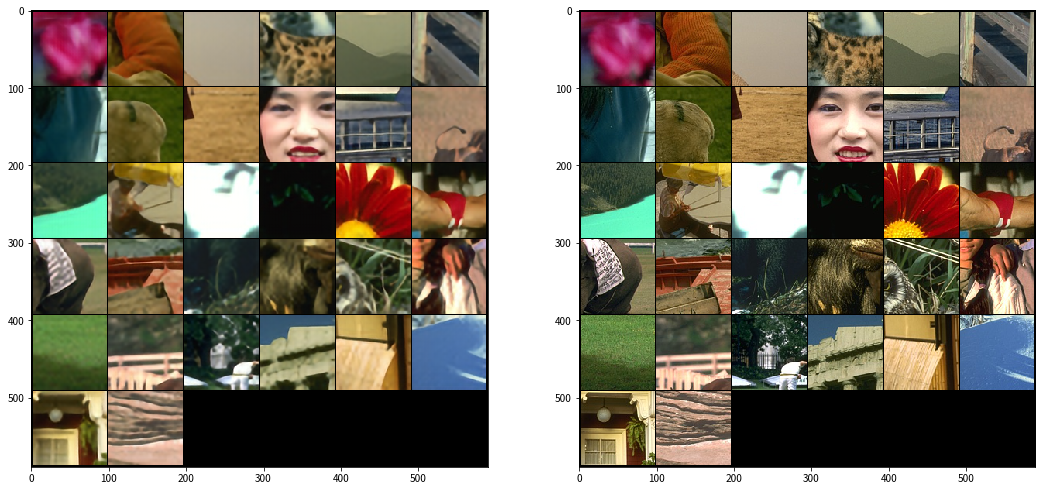

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 9))
plot_grid_images(img_fake, axes[0])
plot_grid_images(img_high, axes[1])

In [31]:
torch.save(gen.state_dict(), '/workdir/dataset/gen_pretrain.hdf5')